In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import os
from ast import literal_eval
import json
from openai_api import OpenAIClient
from typing import List
from collections import defaultdict
import pickle
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

import hdbscan


/home/vqchen_umass_edu/.conda/envs/LMKT/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [3]:
os.getcwd()

'/home/vqchen_umass_edu/dialogue-kt/eedi'

In [4]:
# util

def read_jsonl(filepath):
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            try:
                data.append(json.loads(line.strip()))
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON on line: {line.strip()} - {e}")
    return data

## Filling in missing values

In [45]:
train_df = pd.read_csv("train_gpt-4.1.csv")
val_df = pd.read_csv("val_gpt-4.1.csv")

train_df.iloc[472]["correctness"] = str({
    "turn 1": {
    "summary": "Student greets tutor; does not answer any knowledge-assessing question.",
    "correct": None
    },
    "turn 3": {
    "summary": "Student shares context about their year and confusion with the question; no answer to a specific question.",
    "correct": None
    },
    "turn 5": {
    "summary": "Student gives a vague, incomplete reply when prompted to find 1/3 from 2/3, not answering the conceptual question.",
    "correct": False
    },
    "turn 7": {
    "summary": "Student responds 'math,' not directly answering what to do to get from 2/3 to 1/3; still no mathematical explanation.",
    "correct": False
    },
    "turn 9": {
    "summary": "Student answers, 'fractions,' which is not a specific procedural answer to the question about getting from 2/3 to 1/3.",
    "correct": False
    },
    "turn 11": {
    "summary": "Student again provides a vague, non-specific answer ('maths') rather than the expected mathematical process.",
    "correct": False
    },
    "turn 13": {
    "summary": "Student makes a nonsensical attempt at a calculation and is somewhat off-topic, not answering the prompt about converting 2/3 to 1/3.",
    "correct": False
    },
    "turn 15": {
    "summary": "Student proposes an answer (24), but this is not correct—2/3 of 36 is not the answer being sought; the process is misunderstood.",
    "correct": False
    },
    "turn 17": {
    "summary": "Student responds with emojis, not answering any question.",
    "correct": None
    },
    "turn 19": {
    "summary": "Student replies with 'a,' likely guessing answer choice without calculations; no mathematical justification.",
    "correct": False
    },
    "turn 21": {
    "summary": "Student guesses 'b. b.', likely another random guess, not following tutor's suggested equation.",
    "correct": False
    },
    "turn 23": {
    "summary": "Student answers '6' when prompted for the next calculation (multiplying 36×3); incorrect calculation.",
    "correct": False
    },
    "turn 25": {
    "summary": "Student correctly calculates 36×3=108 as prompted by the tutor.",
    "correct": True
    },
    "turn 27": {
    "summary": "Student calculates 108 divided by 2 = 54, answering correctly when prompted to continue the steps.",
    "correct": True
    },
    "turn 29": {
    "summary": "Student says 'cheers', a closing reply and not an answer to a knowledge-assessing question.",
    "correct": None
    },
    "turn 31": {
    "summary": "Student asks a question about Pythagoras, not answering a knowledge-assessing question.",
    "correct": None
    },
    "turn 33": {
    "summary": "Student asks about expanding/solving algebra, not answering a knowledge-assessing question.",
    "correct": None
    },
    "turn 35": {
    "summary": "Student asks about infinity being a number or a 'fraise'; not answering a knowledge-assessing question.",
    "correct": None
    },
    "turn 37": {
    "summary": "Student says '): oof', expressing emotion; not answering any question.",
    "correct": None
    },
    "turn 39": {
    "summary": "Student asks about 'paskal', not answering a knowledge-assessing question.",
    "correct": None
    }
})

val_df.iloc[296]["correctness"] = str({
    "turn 1": {
    "summary": "The student expresses confusion and asks for help with their work. The learning objective is to gauge the student's readiness and comprehension level.",
    "correct": None
    },
    "turn 2": {
    "summary": "The student attempts to provide an example of a square number by writing '5'2', which presumably means 5^2. The intended objective is to demonstrate an understanding of what a square number is. The response shows an attempt but has a formatting error (should be 5^2 or 25), but the general idea is correct.",
    "correct": None
    },
    "turn 3": {
    "summary": "Asked for the result of 5^2, the student replies with '?', showing they do not know the answer. Intended outcome was for the student to calculate the value.",
    "correct": False
    },
    "turn 4": {
    "summary": "Again, the student replies with '?' when asked what 5 squared is. The learning objective was to have the student compute the value of 5 squared.",
    "correct": False
    },
    "turn 5": {
    "summary": "The student says 'i dont know' when prompted to fill in 5^2 = ___. The intended objective was for the student to state that 5^2 = 25, but the student continues to struggle.",
    "correct": False
    },
    "turn 6": {
    "summary": "When asked for the factors of 25, the student correctly lists '1 5 25'. The objective was to identify the factors of a square number.",
    "correct": True
    },
    "turn 7": {
    "summary": "Asked whether this is an odd number of factors, the student replies with '?'. The learning objective was to check if the student understands the parity of the number of factors.",
    "correct": False
    },
    "turn 8": {
    "summary": "When asked if 3 is an odd number, the student responds with 'ye', which affirms understanding. The learning objective was to get the student to recognize that 3 (number of factors) is odd.",
    "correct": True
    },
    "turn 9": {
    "summary": "The tutor checks for satisfaction with the explanation; the student replies 'yes'. The learning objective was to check for student understanding and comfort.",
    "correct": None
    }
})

train_df.to_csv("train_gpt-4.1_updated.csv", index=False)
val_df.to_csv("val_gpt-4.1_updated.csv", index=False)

## Processing and Formatting baseline common core annotations for training and testing

In [45]:
train_df = pd.read_csv("train_gpt-4.1_updated.csv")
val_df = pd.read_csv("val_gpt-4.1_updated.csv")
test_df = pd.read_csv("test_gpt-4.1.csv")

In [46]:
train_df = pd.concat([train_df, val_df])
train_df.reset_index(inplace=True, drop=True)
all_dfs = [train_df, test_df]

In [7]:
comta_atc = pd.read_csv("../data/annotated/comta_atc.csv")
mathdial_train = pd.read_csv("../data/annotated/mathdial_train_atc.csv")

In [48]:
cc_standards = read_jsonl("../data/src/ATC/standards.jsonl")
cc_id_to_desc = {x["id"]: x["description"] for x in cc_standards}

In [49]:
def next_turn(turn_str):
    return "turn " + str(int(turn_str.split(" ")[-1])+1)

def construct_annotations_column(row):
    kcs = literal_eval(row["kcs_from_question"])
    correctness = literal_eval(row["correctness"])
    return {
        f"turn {i+1}": {
            "correct": correctness[next_turn(turn)]["correct"] if next_turn(turn) in correctness else None,
            "kcs": [cc_id_to_desc[kc] for kc in kcs[turn]["kcs"] if kc != "Default"]
        }
        for i, turn in enumerate(kcs.keys())
    }

for df in all_dfs:
    df["annotation"] = df.apply(construct_annotations_column, axis=1)

In [50]:
def construct_dialogue_column(row):
    turns = literal_eval(row["turns"])
    dialogue = []
    curr_turn = {"turn": 1}
    i = 1
    for turn in turns:
        if turn["role"] == "tutor":
            curr_turn["teacher"] = turn["content"]
        elif turn["role"] == "student":
            if "teacher" not in curr_turn:
                i = 0
                curr_turn = {"turn": 0, "teacher":""}
            curr_turn["student"] = turn["content"]
            dialogue.append(curr_turn)
            i += 1
            curr_turn = {"turn": i}
    if "student" not in curr_turn and "teacher" in curr_turn:
        curr_turn["student"] = ""
        dialogue.append(curr_turn)
    return dialogue

for df in all_dfs:
    df["dialogue"] = df.apply(construct_dialogue_column, axis=1)

In [51]:
for df in all_dfs:
    df["num_turns"] = df["annotation"].apply(lambda turns: max([int(x.split(" ")[-1]) for x in turns.keys()]))
    assert (df["annotation"].apply(lambda turns: max([int(x.split(" ")[-1]) for x in turns.keys()])) == df["num_turns"]).all()

In [52]:
for df in all_dfs:
    df["meta_data"] = df.apply(lambda row: {"num_turns": row["num_turns"]}, axis=1)

In [53]:
kt_dfs = []
for df in all_dfs:
    kt_dfs.append(df[["key", "question", "turns", "annotation", "dialogue", "meta_data"]].reset_index().copy())

In [55]:
kt_dfs[0].to_csv("../data/annotated/eedi_train_atc.csv", index=False)
kt_dfs[1].to_csv("../data/annotated/eedi_test_atc.csv", index=False)

In [56]:
kt_dfs[0].head(100).to_csv("../data/annotated/eedi_temp_train_atc.csv", index=False)
kt_dfs[1].head(100).to_csv("../data/annotated/eedi_temp_test_atc.csv", index=False)

## Fixing issue with previously annotated dialogues

In [78]:
train_data = pd.read_csv("train_gpt-4.1_updated.csv")

In [76]:
# did not order gpt responses in same order as original prompt order
# the following code recovers the prompt to response mapping
with open("kc_prompts1.json") as prompts1_file:
    prompts1 = json.load(prompts1_file)
with open("kc_prompts2.json") as prompts2_file:
    prompts2 = json.load(prompts2_file)

In [79]:
def get_first_n_turn_texts(turn_str, n):
    turns = literal_eval(turn_str)
    return "\n".join([turns[i]["content"] for i in range(n)])
train_data_turn_texts = train_data["turns"].apply(lambda turn: get_first_n_turn_texts(turn, 3))
assert len(train_data) == len(train_data_turn_texts.unique())

In [80]:
def get_first_n_prompt_turn_texts(prompt, n):
    prompts_split_by_teacher = prompt.split("[BEGIN DIALOGUE]")[1].split("Teacher Turn ")
    prompts_split_by_student = [y for x in prompts_split_by_teacher for y in x.split("Student Turn ")]
    prompts_split_by_turn = [" ".join(x.split(" ")[1:]) for x in prompts_split_by_student]
    all_prompt_turns = [x.split("\n")[0] for x in prompts_split_by_turn]
    return "\n".join(all_prompt_turns[1:n+1])
all_kc_prompts = prompts1 + prompts2
prompt_turn_texts = [get_first_n_prompt_turn_texts(x, 3) for x in all_kc_prompts]
assert len(all_kc_prompts) == len([get_first_n_prompt_turn_texts(x, 3) for x in all_kc_prompts])

In [82]:
train_data_to_prompt_mapping = train_data_turn_texts.apply(
    lambda text: prompt_turn_texts.index(text) if text in prompt_turn_texts else -1
)
prompt_to_train_mapping = {prompt_idx: idx for idx, prompt_idx in train_data_to_prompt_mapping.items()}
missing_prompt_idx = train_data_turn_texts[train_data_to_prompt_mapping[train_data_to_prompt_mapping == -1].index].index
processed_prompts_idx = [idx for idx in range(len(all_kc_prompts)) if idx not in missing_prompt_idx]
train_data_idx_per_prompt = [prompt_to_train_mapping[x] for x in processed_prompts_idx]
train_data_with_prompts = train_data.loc[train_data_idx_per_prompt].copy()

In [85]:
kc_responses1 = read_jsonl("batches/batch_6924265dbad48190a44ba1e1df476172_output.jsonl")
kc_responses2 = read_jsonl("batches/batch_69249122d348819082975ba5bfa5891a_output.jsonl")
all_kc_responses = [x["response"]["body"]["choices"][0]["message"]["content"] for x in kc_responses1 + kc_responses2]
kc_responses_per_prompt = [all_kc_responses[idx] for idx in processed_prompts_idx]

In [88]:
correctness_responses1 = read_jsonl("batches/batch_6924aebb8ff881909e54bf39d20fc273_output.jsonl")
correctness_responses2 = read_jsonl("batches/batch_6924c8610de881908fb0340933b20892_output.jsonl")
all_correctness_responses = [x["response"]["body"]["choices"][0]["message"]["content"] for x in correctness_responses1 + correctness_responses2]
correctness_responses_per_prompt = [all_correctness_responses[idx] for idx in processed_prompts_idx]

## KC generation and tagging using gpt 4.1

In [5]:
client = OpenAIClient(use_azure_client=False)

In [6]:
def convert_turns_to_dialogue(turns):
    curr_turn = {"teacher":"", "student":"", "turn":0}
    dialogue = []
    for turn in turns:
        curr_role = "teacher" if turn["role"] == "tutor" else "student"
        curr_turn[curr_role] = turn["content"]
        if curr_role == "student":
            curr_turn["turn"] += 1
            dialogue.append({**curr_turn})
            curr_turn["teacher"] = ""
            curr_turn["student"] = ""
    return dialogue

In [ ]:
KC_EXAMPLES = """ "Apply and extend previous understandings of operations with fractions to add, subtract, multiply, and divide rational numbers.", and "Use facts about supplementary, complementary, vertical, and adjacent angles in a multi-step problem to write and solve simple equations for an unknown angle in a figure."."""

EEDI_DIALOGUE_DESC = "the student is attempting to solve a math problem. You are also given this problem."
template_prompt = """You are an experienced math teacher and education expert. You are given a dialogue between a student and teacher where {desc} Your job is to list the math concepts/skills that can be used to classify the learning objectives most relevant to this problem. Please follow these instructions carefully when making your prediction:
- Each math concept/skill should be a short description of a single learning objective. They should be generic enough so that they can be applied across dialogues and educational settings. Some examples (unrelated to this question) are{examples}
- Teacher turns are often phrased as questions. In these cases, choose math concepts/skills that the student will need in order to respond correctly to the teacher's question. Some turns may be unrelated to solving the original math problem, and should not receive any math concepts/skills.
- Your final response should be a JSON object using the template: result = {{"turn 1": ["math concept/skill 1", "math concept/skill 2", ...], "turn 2": ...}}"""
eedi_system_prompt = template_prompt.format(desc=EEDI_DIALOGUE_DESC, examples=KC_EXAMPLES)

def get_dialogue_text(dialogue: List[dict], turn_idx: int = None, include_labels: bool = False, tag_wrapper: bool = True):
    lines = []
    for turn in dialogue:
        if turn["teacher"]:
            lines.append(f"Teacher Turn {turn['turn']}: {turn['teacher']}")
        # When turn_idx is given, stop after teacher utterance for that turn
        # Student utterance not included since would leak the correctness label in KT objective
        if turn_idx is not None and turn_idx == turn["turn"]:
            break
        if turn["student"]:
            lines.append(f"Student Turn {turn['turn']}: {turn['student']}")
    prompt = "\n".join(lines)
    if tag_wrapper:
        prompt = "[BEGIN DIALOGUE]\n" + prompt + "\n[END DIALOGUE]"
    return prompt

def anno_base_user_prompt(sample: dict):
    prompt = "[BEGIN PROBLEM]\n" + sample["question"] + "\n[END PROBLEM]"
    prompt += "\n\n"
    prompt += get_dialogue_text(sample["dialogue"])
    max_turn = sample["dialogue"][-1]["turn"]
    prompt += f"\n\nYour final response should have an entry for exactly {max_turn} turn{f's (1-{max_turn})' if max_turn > 1 else ''}."
    return prompt

In [8]:
correctness_template = """You are an experienced math teacher and education expert. You are given a dialogue between a student and teacher where {desc} Your job is to determine if the student has correctly answered each of the teacher's questions in the dialogue. Please follow these instructions carefully when making your prediction:
- The prediction should be "na" if the teacher asks a question that 1) does not attempt to assess the student's knowledge, or 2) does not necessarily have a right or wrong answer.
- If the question 1) does assess student knowledge and has a correct answer, and 2) the student does not respond directly to the question, then the prediction should be "false".
- In addition to your predictions, write a short summary of each turn, including the intended learning objectives, and explain why the student's response is right or wrong.
- Your final prediction should be a JSON object using the template: result = {{"turn 1": {{"summary": "insert summary", "correct": "true/false/na"}}, "turn 2": ...}}"""
eedi_correctness = correctness_template.format(desc=EEDI_DIALOGUE_DESC)

def anno_correctness_user_prompt(sample: dict):
    return anno_base_user_prompt(sample)

In [9]:
def make_kc_prompts(data):
    eedi_prompts = [anno_base_user_prompt(sample) for _, sample in data.iterrows()]
    return eedi_prompts

def make_correctness_prompts(data):
    eedi_prompts = [anno_correctness_user_prompt(sample) for _, sample in data.iterrows()]
    return eedi_prompts

def get_annotated_data(prompts, system_prompt, model="gpt-4.1", batched=False):
    generation_args = {
        "max_completion_tokens": 5000
    }
    sm_cache, uncached_prompts, batch_id = client.get_responses(prompts, model, system_prompt, generation_args, batch_api=batched)
    return sm_cache, uncached_prompts, batch_id, generation_args

def annotate_kcs(data, model="gpt-4.1", batched=False):
    data = data.copy()
    data["dialogue"] = data["turns"].apply(lambda turn: convert_turns_to_dialogue(literal_eval(turn)))
    kc_prompts = make_kc_prompts(data)
    return *get_annotated_data(kc_prompts, eedi_system_prompt, model=model, batched=batched), kc_prompts

def annotate_correctness(data, model="gpt-4.1", batched=False):
    data = data.copy()
    data["dialogue"] = data["turns"].apply(lambda turn: convert_turns_to_dialogue(literal_eval(turn)))
    correctness_prompts = make_correctness_prompts(data)
    return *get_annotated_data(correctness_prompts, eedi_correctness, model=model, batched=batched), correctness_prompts

In [6]:
def retrieve_batch_responses(batch_id, prompts, uncached_prompts, sm_cache, generation_args):
    batch_response = client.client.batches.retrieve(batch_id)
    print(batch_response)
    responses = client.retrieve_batch_api_responses(batch_response, prompts, uncached_prompts, sm_cache, generation_args)
    return responses

In [11]:
train_data = pd.read_csv("train_gpt-4.1_updated.csv")
val_data = pd.read_csv("val_gpt-4.1_updated.csv")
test_data = pd.read_csv("test_gpt-4.1.csv")

In [12]:
train_data = pd.concat([train_data, val_data], axis=0).reset_index(drop=True)

In [22]:
train_data1 = train_data.iloc[:526].copy()
train_data2 = train_data.iloc[526:1052].copy()
train_data3 = train_data.iloc[1052:].copy()

partitioned_data = {
    "train1": train_data1,
    "train2": train_data2,
    "train3": train_data3,
    "test": test_data.copy()
}

In [24]:
def annotate_kcs_save(data, name):
    sm_cache, uncached_prompts, batch_id, generation_args, kc_prompts = annotate_kcs(data, batched=True)
    with open(f"batch_info/{name}_kcs.pkl", "wb") as f:
        pickle.dump((sm_cache, uncached_prompts, batch_id, generation_args, kc_prompts), f, protocol=pickle.HIGHEST_PROTOCOL)

def annotate_correctness_save(data, name):
    sm_cache, uncached_prompts, batch_id, generation_args, correctness_prompts = annotate_correctness(data, batched=True)
    with open(f"batch_info/{name}_correctness.pkl", "wb") as f:
        pickle.dump((sm_cache, uncached_prompts, batch_id, generation_args, correctness_prompts), f, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
annotate_kcs_save(partitioned_data["train1"], "train1")

Calling batch API - 526 prompts, sending 526 new requests
{
  "id": "file-Ng74r298tD11dVct8tzg4Y",
  "bytes": 1907614,
  "created_at": 1766200496,
  "filename": "temp.jsonl",
  "object": "file",
  "purpose": "batch",
  "status": "processed",
  "status_details": null,
  "expires_at": 1767410096
}
{
  "id": "batch_694614b103588190832cd01952e6eb46",
  "completion_window": "24h",
  "created_at": 1766200497,
  "endpoint": "/v1/chat/completions",
  "input_file_id": "file-Ng74r298tD11dVct8tzg4Y",
  "object": "batch",
  "status": "validating",
  "cancelled_at": null,
  "cancelling_at": null,
  "completed_at": null,
  "error_file_id": null,
  "errors": null,
  "expired_at": null,
  "expires_at": 1766286897,
  "failed_at": null,
  "finalizing_at": null,
  "in_progress_at": null,
  "metadata": null,
  "output_file_id": null,
  "request_counts": {
    "completed": 0,
    "failed": 0,
    "total": 0
  },
  "model": null,
  "usage": {
    "input_tokens": 0,
    "output_tokens": 0,
    "total_tokens"

In [26]:
annotate_correctness_save(partitioned_data["train1"], "train1")

Calling batch API - 526 prompts, sending 526 new requests
{
  "id": "file-Jj4XkrzsPzB9DTa6qf8tuZ",
  "bytes": 1745080,
  "created_at": 1766201697,
  "filename": "temp.jsonl",
  "object": "file",
  "purpose": "batch",
  "status": "processed",
  "status_details": null,
  "expires_at": 1767411297
}
{
  "id": "batch_69461961b6548190a71730264c74aa46",
  "completion_window": "24h",
  "created_at": 1766201697,
  "endpoint": "/v1/chat/completions",
  "input_file_id": "file-Jj4XkrzsPzB9DTa6qf8tuZ",
  "object": "batch",
  "status": "validating",
  "cancelled_at": null,
  "cancelling_at": null,
  "completed_at": null,
  "error_file_id": null,
  "errors": null,
  "expired_at": null,
  "expires_at": 1766288097,
  "failed_at": null,
  "finalizing_at": null,
  "in_progress_at": null,
  "metadata": null,
  "output_file_id": null,
  "request_counts": {
    "completed": 0,
    "failed": 0,
    "total": 0
  },
  "model": null,
  "usage": {
    "input_tokens": 0,
    "output_tokens": 0,
    "total_tokens"

In [27]:
annotate_kcs_save(partitioned_data["train2"], "train2")

Calling batch API - 526 prompts, sending 526 new requests
{
  "id": "file-KArXUUCf1cxoPUp3ux7ELT",
  "bytes": 1916360,
  "created_at": 1766202081,
  "filename": "temp.jsonl",
  "object": "file",
  "purpose": "batch",
  "status": "processed",
  "status_details": null,
  "expires_at": 1767411681
}
{
  "id": "batch_69461ae1ed908190873d1e7730cc27ee",
  "completion_window": "24h",
  "created_at": 1766202081,
  "endpoint": "/v1/chat/completions",
  "input_file_id": "file-KArXUUCf1cxoPUp3ux7ELT",
  "object": "batch",
  "status": "validating",
  "cancelled_at": null,
  "cancelling_at": null,
  "completed_at": null,
  "error_file_id": null,
  "errors": null,
  "expired_at": null,
  "expires_at": 1766288481,
  "failed_at": null,
  "finalizing_at": null,
  "in_progress_at": null,
  "metadata": null,
  "output_file_id": null,
  "request_counts": {
    "completed": 0,
    "failed": 0,
    "total": 0
  },
  "model": null,
  "usage": {
    "input_tokens": 0,
    "output_tokens": 0,
    "total_tokens"

In [28]:
annotate_correctness_save(partitioned_data["train2"], "train2")

Calling batch API - 526 prompts, sending 526 new requests
{
  "id": "file-JtgPKVRNXXdDmbk3kGjVBa",
  "bytes": 1753826,
  "created_at": 1766202282,
  "filename": "temp.jsonl",
  "object": "file",
  "purpose": "batch",
  "status": "processed",
  "status_details": null,
  "expires_at": 1767411882
}
{
  "id": "batch_69461baa6ba48190ae2037f0a8f3f0a7",
  "completion_window": "24h",
  "created_at": 1766202282,
  "endpoint": "/v1/chat/completions",
  "input_file_id": "file-JtgPKVRNXXdDmbk3kGjVBa",
  "object": "batch",
  "status": "validating",
  "cancelled_at": null,
  "cancelling_at": null,
  "completed_at": null,
  "error_file_id": null,
  "errors": null,
  "expired_at": null,
  "expires_at": 1766288682,
  "failed_at": null,
  "finalizing_at": null,
  "in_progress_at": null,
  "metadata": null,
  "output_file_id": null,
  "request_counts": {
    "completed": 0,
    "failed": 0,
    "total": 0
  },
  "model": null,
  "usage": {
    "input_tokens": 0,
    "output_tokens": 0,
    "total_tokens"

In [29]:
annotate_kcs_save(partitioned_data["train3"], "train3")

Calling batch API - 524 prompts, sending 524 new requests
{
  "id": "file-9vWX4v7no8sVm7bMK2P9Ug",
  "bytes": 1915087,
  "created_at": 1766203328,
  "filename": "temp.jsonl",
  "object": "file",
  "purpose": "batch",
  "status": "processed",
  "status_details": null,
  "expires_at": 1767412928
}
{
  "id": "batch_69461fc0d4748190809ed34554bfdfda",
  "completion_window": "24h",
  "created_at": 1766203328,
  "endpoint": "/v1/chat/completions",
  "input_file_id": "file-9vWX4v7no8sVm7bMK2P9Ug",
  "object": "batch",
  "status": "validating",
  "cancelled_at": null,
  "cancelling_at": null,
  "completed_at": null,
  "error_file_id": null,
  "errors": null,
  "expired_at": null,
  "expires_at": 1766289728,
  "failed_at": null,
  "finalizing_at": null,
  "in_progress_at": null,
  "metadata": null,
  "output_file_id": null,
  "request_counts": {
    "completed": 0,
    "failed": 0,
    "total": 0
  },
  "model": null,
  "usage": {
    "input_tokens": 0,
    "output_tokens": 0,
    "total_tokens"

In [135]:
annotate_correctness_save(partitioned_data["train3"], "train3")

Calling batch API - 524 prompts, sending 524 new requests
{
  "id": "file-Us6X4FnCSQ33DyZzyoAni2",
  "bytes": 1753171,
  "created_at": 1766207469,
  "filename": "temp.jsonl",
  "object": "file",
  "purpose": "batch",
  "status": "processed",
  "status_details": null,
  "expires_at": 1767417069
}
{
  "id": "batch_69462fee6a748190b8726d538892efa5",
  "completion_window": "24h",
  "created_at": 1766207470,
  "endpoint": "/v1/chat/completions",
  "input_file_id": "file-Us6X4FnCSQ33DyZzyoAni2",
  "object": "batch",
  "status": "validating",
  "cancelled_at": null,
  "cancelling_at": null,
  "completed_at": null,
  "error_file_id": null,
  "errors": null,
  "expired_at": null,
  "expires_at": 1766293870,
  "failed_at": null,
  "finalizing_at": null,
  "in_progress_at": null,
  "metadata": null,
  "output_file_id": null,
  "request_counts": {
    "completed": 0,
    "failed": 0,
    "total": 0
  },
  "model": null,
  "usage": {
    "input_tokens": 0,
    "output_tokens": 0,
    "total_tokens"

In [136]:
annotate_kcs_save(partitioned_data["test"], "test")

Calling batch API - 395 prompts, sending 395 new requests
{
  "id": "file-K1SXNt9y74RhwTPyYUL5FG",
  "bytes": 1425165,
  "created_at": 1766207694,
  "filename": "temp.jsonl",
  "object": "file",
  "purpose": "batch",
  "status": "processed",
  "status_details": null,
  "expires_at": 1767417294
}
{
  "id": "batch_694630ce93dc8190bfc237fe0f0ea88a",
  "completion_window": "24h",
  "created_at": 1766207694,
  "endpoint": "/v1/chat/completions",
  "input_file_id": "file-K1SXNt9y74RhwTPyYUL5FG",
  "object": "batch",
  "status": "validating",
  "cancelled_at": null,
  "cancelling_at": null,
  "completed_at": null,
  "error_file_id": null,
  "errors": null,
  "expired_at": null,
  "expires_at": 1766294094,
  "failed_at": null,
  "finalizing_at": null,
  "in_progress_at": null,
  "metadata": null,
  "output_file_id": null,
  "request_counts": {
    "completed": 0,
    "failed": 0,
    "total": 0
  },
  "model": null,
  "usage": {
    "input_tokens": 0,
    "output_tokens": 0,
    "total_tokens"

In [137]:
annotate_correctness_save(partitioned_data["test"], "test")

Calling batch API - 395 prompts, sending 395 new requests
{
  "id": "file-KHcWfnLf1fbTRrr373zGJf",
  "bytes": 1303110,
  "created_at": 1766207947,
  "filename": "temp.jsonl",
  "object": "file",
  "purpose": "batch",
  "status": "processed",
  "status_details": null,
  "expires_at": 1767417547
}
{
  "id": "batch_694631cbd330819089988f0d1c5620b3",
  "completion_window": "24h",
  "created_at": 1766207947,
  "endpoint": "/v1/chat/completions",
  "input_file_id": "file-KHcWfnLf1fbTRrr373zGJf",
  "object": "batch",
  "status": "validating",
  "cancelled_at": null,
  "cancelling_at": null,
  "completed_at": null,
  "error_file_id": null,
  "errors": null,
  "expired_at": null,
  "expires_at": 1766294347,
  "failed_at": null,
  "finalizing_at": null,
  "in_progress_at": null,
  "metadata": null,
  "output_file_id": null,
  "request_counts": {
    "completed": 0,
    "failed": 0,
    "total": 0
  },
  "model": null,
  "usage": {
    "input_tokens": 0,
    "output_tokens": 0,
    "total_tokens"

In [7]:
def retrieve_saved_responses(name, data_type):
    assert name in ["train1", "train2", "train3", "test"]
    assert data_type in ["kcs", "correctness", "merge"]
    with open(f"batch_info/{name}_{data_type}.pkl", "rb") as f:
        loaded_tuple = pickle.load(f)
    sm_cache, uncached_prompts, batch_id, generation_args, all_prompts = loaded_tuple
    all_responses = retrieve_batch_responses(batch_id, all_prompts, uncached_prompts, sm_cache, generation_args)
    return all_responses

In [120]:
with open(f"batch_info/train1_correctness.pkl", "rb") as f:
    loaded_tuple = pickle.load(f)
    prompts = loaded_tuple[-1]
prompts[221]

"[BEGIN PROBLEM]\nQuestion Text: What is the gradient of this line?\nQuestion Image: A set of axes with a graph drawn on. The graph passes through the points (0,3) and (1,1).\nAnswer A Text: \\( -2 \\)\nAnswer B Text: \\( -1 \\)\nAnswer C Text: \\( -1.5 \\)\nAnswer D Text: \\( -0.5 \\)\n[END PROBLEM]\n\n[BEGIN DIALOGUE]\nTeacher Turn 1: Hello Kareem 😁👋\nStudent Turn 1: Hi how do I work out the gradient. I’m stuck\nTeacher Turn 2: No worries 😊👌let's have a look! To work out the gradient, we do the change in y/ change in x. What I mean by that is, how far have we gone up or down / how far right have we gone... In order to work out these values, we pick two points on the straight line that we know the coordinates of\nStudent Turn 2: Well we do have a longer line in the x axes\nTeacher Turn 3: Is this making sense so far? 🙂👍. So for example, we can pick the points... (0,3) and (2,-1) because we know those coordinates and those points lie on the line\nStudent Turn 3: Yes\nTeacher Turn 4: Aw

In [38]:
train_data["question"].iloc[2]

'Question Text: Which of the following triangles does not have the same area as the others?\nAnswer A Image: A right angled triangle with base 4 and height 6\nAnswer B Image: A scalene triangle with base 3, perpendicular height 6, and slanted height 8\nAnswer C Image: An isosceles triangle with base 8, other sides 5, and perpendicular height 3\nAnswer D Text: They all have the same area'

In [8]:
kcs1 = retrieve_saved_responses("train1", "kcs")
kcs2 = retrieve_saved_responses("train2", "kcs")
kcs3 = retrieve_saved_responses("train3", "kcs")
kcs_test = retrieve_saved_responses("test", "kcs")

Batch(id='batch_694614b103588190832cd01952e6eb46', completion_window='24h', created_at=1766200497, endpoint='/v1/chat/completions', input_file_id='file-Ng74r298tD11dVct8tzg4Y', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1766201669, error_file_id=None, errors=None, expired_at=None, expires_at=1766286897, failed_at=None, finalizing_at=1766201611, in_progress_at=1766200560, metadata=None, output_file_id='file-4sver5x2PshPyy3qJZAHr5', request_counts=BatchRequestCounts(completed=526, failed=0, total=526), model='gpt-4.1-2025-04-14', usage={'input_tokens': 447695, 'output_tokens': 90579, 'total_tokens': 538274, 'input_tokens_details': {'cached_tokens': 0}, 'output_tokens_details': {'reasoning_tokens': 0}})
526 / 526 prompts succeeded
Batch(id='batch_69461ae1ed908190873d1e7730cc27ee', completion_window='24h', created_at=1766202081, endpoint='/v1/chat/completions', input_file_id='file-KArXUUCf1cxoPUp3ux7ELT', object='batch', status='completed', canc

In [9]:
correctness1 = retrieve_saved_responses("train1", "correctness")
correctness2 = retrieve_saved_responses("train2", "correctness")
correctness3 = retrieve_saved_responses("train3", "correctness")
correctness_test = retrieve_saved_responses("test", "correctness")

Batch(id='batch_69461961b6548190a71730264c74aa46', completion_window='24h', created_at=1766201697, endpoint='/v1/chat/completions', input_file_id='file-Jj4XkrzsPzB9DTa6qf8tuZ', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1766201985, error_file_id=None, errors=None, expired_at=None, expires_at=1766288097, failed_at=None, finalizing_at=1766201933, in_progress_at=1766201759, metadata=None, output_file_id='file-Ua834ZEu8E97B2B1BBxKFZ', request_counts=BatchRequestCounts(completed=526, failed=0, total=526), model='gpt-4.1-2025-04-14', usage={'input_tokens': 420869, 'output_tokens': 267453, 'total_tokens': 688322, 'input_tokens_details': {'cached_tokens': 0}, 'output_tokens_details': {'reasoning_tokens': 0}})
526 / 526 prompts succeeded
Batch(id='batch_69461baa6ba48190ae2037f0a8f3f0a7', completion_window='24h', created_at=1766202282, endpoint='/v1/chat/completions', input_file_id='file-JtgPKVRNXXdDmbk3kGjVBa', object='batch', status='completed', can

## Clustering KCs and mapping back to original tagged responses

In [10]:
def process_kc_responses(responses):
    all_kcs = set()
    output_responses = []
    for response in responses:
        tagged_response = literal_eval(response.split("result = ")[1])
        output_responses.append(tagged_response)
        for kc_list in tagged_response.values():
            for kc in kc_list:
                all_kcs.add(kc)
    return all_kcs, output_responses

def process_correctness_responses(responses):
    processed_responses = []
    i = 0
    for response in responses:
        try:
            correctness = literal_eval(response.split("Explanation:")[0].split("result = ")[-1])
        except:
            print(i, response)
            raise Exception("eee")
        mapping = {"true": True, "false": False, "na": None}
        for turn in correctness:
            correctness_label = correctness[turn]["correct"]
            assert correctness_label in mapping.keys()
            correctness[turn]["correct"] = mapping[correctness_label]
        processed_responses.append(correctness)
        i += 1
    return processed_responses

In [11]:
# fixing issue with output 226
temp_result = {f"turn {i}": [] for i in range(1, 26)}
temp_result["turn 2"] = ["Round numbers to a given number of significant figures."]
temp_result["turn 5"] = ["Round numbers to a given number of significant figures."]
temp_result["turn 7"] = ["Round numbers to a given number of significant figures."]
temp_result["turn 8"] = ["Identify the first significant figure in a number."]
temp_result["turn 9"] = ["Round numbers to a given number of significant figures."]
temp_result["turn 10"] = ["Round numbers to a given number of significant figures."]
temp_result["turn 11"] = ["Round numbers to a given number of significant figures."]
temp_result["turn 12"] = ["Multiply whole numbers and decimals."]
temp_result["turn 13"] = ["Identify the first significant figure in a number."]
temp_result["turn 14"] = ["Identify the first significant figure in a number."]
temp_result["turn 15"] = ["Round numbers to a given number of significant figures."]
temp_result["turn 16"] = ["Divide decimals by decimals."]
temp_result["turn 17"] = ["Divide decimals by decimals."]
temp_result["turn 18"] = ["Understand the relationship between division by a decimal and multiplication."]
temp_result["turn 19"] = ["Understand the relationship between division by a decimal and multiplication."]
temp_result["turn 20"] = ["Understand the relationship between division by a decimal and multiplication."]
temp_result["turn 21"] = ["Interpret the result of an estimation to select the correct answer from multiple choices."]
kcs1[226] = "result = " + json.dumps(temp_result)

In [12]:
temp_result = {f"turn {i}": [] for i in range(1, 29)}
temp_result["turn 2"] = ["Find the square root of a perfect square."]
temp_result["turn 4"] = ["Find the square root of a perfect square."]
temp_result["turn 5"] = ["Justify a solution using properties of square roots."]
temp_result["turn 7"] = ["Find the square root of a perfect square."]
temp_result["turn 10"] = ["Find the square root of a perfect square."]
temp_result["turn 11"] = ["Understand and use the definition of a square root."]
temp_result["turn 12"] = ["Understand and use the definition of a square root."]
temp_result["turn 13"] = ["Understand and use the definition of a square root."]
temp_result["turn 15"] = ["Add two whole numbers."]
temp_result["turn 16"] = ["Find the square root of a perfect square."]
temp_result["turn 17"] = ["Compare two calculations involving square roots."]
temp_result["turn 20"] = ["Find the square root of a perfect square."]
temp_result["turn 21"] = ["Find the square root of a perfect square."]
temp_result["turn 22"] = ["Add two square roots of perfect squares."]
temp_result["turn 23"] = ["Find the square root of a perfect square."]
temp_result["turn 24"] = ["Add two square roots of perfect squares."]
temp_result["turn 25"] = ["Add two whole numbers."]
temp_result["turn 26"] = ["Add two whole numbers."]
temp_result["turn 27"] = ["Justify a solution using properties of square roots."]
kcs3[48] = "result = " + json.dumps(temp_result)

In [13]:
temp_result = {f"turn {i}": [] for i in range(1, 38)}
temp_result["turn 3"] = [
    "Understand and use ratios in the form a:b and convert to the form 1:n.",
    "Divide fractions by fractions."
]
temp_result["turn 10"] = [
    "Understand and use ratios in the form a:b and convert to the form 1:n."
]
temp_result["turn 11"] = [
    "Understand and use multiplication and division to simplify ratios."
]
temp_result["turn 12"] = [
    "Use division to scale ratios."
]
temp_result["turn 13"] = [
    "Use division to scale ratios."
]
temp_result["turn 15"] = [
    "Divide whole numbers and interpret results as decimals and fractions."
]
temp_result["turn 16"] = [
    "Express ratios in the form 1:n using decimals."
]
temp_result["turn 17"] = [
    "Apply the process of converting ratios to the form 1:n with fractions."
]
temp_result["turn 18"] = [
    "Divide fractions by fractions."
]
temp_result["turn 19"] = [
    "Divide fractions by fractions."
]
temp_result["turn 22"] = [
    "Divide fractions by themselves to obtain 1."
]
temp_result["turn 24"] = [
    "Divide fractions by themselves to obtain 1."
]
temp_result["turn 27"] = [
    "Apply the same operation to both terms of a ratio."
]
temp_result["turn 28"] = [
    "Divide fractions by fractions."
]
temp_result["turn 29"] = [
    "Divide fractions by fractions."
]
temp_result["turn 30"] = [
    "Understand and apply the 'keep, change, flip' method for dividing fractions."
]
temp_result["turn 31"] = [
    "Understand and apply the 'keep, change, flip' method for dividing fractions."
]
temp_result["turn 32"] = [
    "Multiply fractions."
]
temp_result["turn 33"] = [
    "Multiply fractions."
]
temp_result["turn 34"] = [
    "Convert decimals to fractions."
]
temp_result["turn 35"] = [
    "Convert decimals to fractions."
]
kcs3[409] = "result = " + json.dumps(temp_result)

In [14]:
temp_result = {f"turn {i}": [] for i in range(1, 16)}
temp_result["turn 3"] = [
    "Find the total number of data points by summing frequencies in a frequency table."
]
temp_result["turn 5"] = [
    "Find the total number of data points by summing frequencies in a frequency table."
]
temp_result["turn 6"] = [
    "Determine the position of the median in a data set using the formula (n+1)/2."
]
temp_result["turn 7"] = [
    "Determine the position of the median in a data set using the formula (n+1)/2."
]
temp_result["turn 8"] = [
    "Interpret a frequency table to list data values in order."
]
temp_result["turn 9"] = [
    "Interpret a frequency table to list data values in order."
]
temp_result["turn 10"] = [
    "Use cumulative frequency to locate a specific data value in an ordered list."
]
temp_result["turn 11"] = [
    "Use cumulative frequency to locate a specific data value in an ordered list."
]
temp_result["turn 13"] = [
    "Identify the median value from an ordered data set using its position."
]
kcs_test[47] = "result = " + json.dumps(temp_result)

In [15]:
all_kcs, all_turn_kcs = process_kc_responses(kcs1 + kcs2 + kcs3 + kcs_test)
kc_list = list(all_kcs)

In [16]:
len(kc_list)

7353

In [17]:
correctness1[221] = """result = {
"turn 1": {
"summary": "The teacher greets the student. No assessment or content question here.",
"correct": "na"
},
"turn 2": {
"summary": "Student asks for help on finding the gradient. This is not an answer to a teacher's knowledge-check question.",
"correct": "na"
},
"turn 3": {
"summary": "The teacher checks if the method explanation makes sense. The student answers 'Yes' to confirm understanding.",
"correct": "true"
},
"turn 4": {
"summary": "Teacher asks for the change in y values going from 3 to -1 (should be -4). Student says '4 less', which is an informal, but correct, interpretation.",
"correct": "true"
},
"turn 5": {
"summary": "Teacher confirms that -4 is correct for change in y. Asks if that is accepted. Student says 'Yes.'",
"correct": "true"
},
"turn 6": {
"summary": "Teacher asks what the change in x is from 0 to 2 (should be 2). Student responds 'Plus 2', which is correct.",
"correct": "true"
},
"turn 7": {
"summary": "Teacher reminds the student of the gradient formula and commends them. Student applies this and asks if the answer is negative 2 (correct calculation for the points teacher used).",
"correct": "true"
},
"turn 8": {
"summary": "Teacher confirms student's answer. Student requests to exit and reports understanding. This is not a knowledge-assessment question.",
"correct": "na"
}
}"""

In [18]:
all_correctness = process_correctness_responses(correctness1 + correctness2 + correctness3 + correctness_test)

In [19]:
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(kc_list, convert_to_numpy=True)
print(embeddings.shape)

/home/vqchen_umass_edu/.conda/envs/LMKT/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


(7353, 384)


In [20]:
clusterer = hdbscan.HDBSCAN(
    metric="euclidean",
    min_cluster_size=2,
    min_samples=1
)

labels = clusterer.fit_predict(embeddings)

cluster_to_kcs = defaultdict(list)
for s, l in zip(kc_list, labels):
    cluster_to_kcs[l].append(s)

In [21]:
print("number of clusters:", len(cluster_to_kcs) - 1)
print("number of outliers:", len(cluster_to_kcs[-1]))
print("average cluster size:", sum([len(cluster_to_kcs[x]) for x in cluster_to_kcs.keys() if x != -1]) / (len(cluster_to_kcs) - 1))

number of clusters: 1705
number of outliers: 2318
average cluster size: 2.9530791788856305


In [22]:
hdbscan_labels = clusterer.labels_
hdbscan_probs = clusterer.probabilities_
reps = {}
best_probs = []
for x in set(hdbscan_labels):
    if x == -1:
        continue
    idx = np.where(hdbscan_labels == x)[0]
    best = idx[np.argmax(hdbscan_probs[idx])]
    best_probs.append(np.max(hdbscan_probs[idx]))
    reps[x] = best

In [24]:
all([x == 1 for x in best_probs])

True

In [26]:
reduced_kc_list = [kc_list[x] for x in reps.values()] + cluster_to_kcs[-1]

In [27]:
len(reduced_kc_list)

4023

In [28]:
k = 385
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(reduced_kc_list, convert_to_numpy=True)
embeddings_norm = normalize(embeddings)

clusterer = AgglomerativeClustering(
    n_clusters=k,
    metric="cosine",
    linkage="average"
)

labels = clusterer.fit_predict(embeddings_norm)

cluster_to_reduced_kcs = defaultdict(list)
for s, l in zip(reduced_kc_list, labels):
    cluster_to_reduced_kcs[l].append(s)

In [29]:
print("number of clusters:", len(cluster_to_reduced_kcs))
print("average cluster size:", sum([len(cluster_to_reduced_kcs[x]) for x in cluster_to_reduced_kcs.keys()]) / (len(cluster_to_reduced_kcs)))

number of clusters: 385
average cluster size: 10.449350649350649


In [200]:
KC_MERGE_SYSTEM_PROMPT = """You are an experienced computer science teacher and education expert. You will be provided with a list of knowledge components (KCs) that may vary in wording but sometimes refer to the same or related underlying concepts or skills.

The KCs will be given in the format: ["KC 1 name", "KC 2 name", ..., "KC k name"]

Your task is to:
1. Carefully examine all the KCs in the list to ensure none are overlooked.
2. Reason explicitly whether the KCs collectively refer to the same underlying concept or skill, or if they are related but represent distinct or complementary aspects of a broader theme.
3. Based on your reasoning:
    - If the KCs refer to the same concept or skill, select one KC from the list that best represents the group — choose the one that is most clearly worded, generalizable, and inclusive of the others.
    - If the KCs are related but too distinct to be represented by a single KC, create a brief and meaningful summary name that captures the broader theme shared by the KCs. The summary name must not contain the word “and”.

Return your output strictly in the following JSON format:
{
  "reasoning": "...",        // Exactly one sentence explaining your reasoning
  "representative_kc": "..." , // Selected KC if applicable, otherwise null
  "summary_name": "..." ,       // Summary name if representative KC not chosen, otherwise null
}"""

def create_kc_merge_user_prompt(kcs):
    return f"The knowledge components list is:\n{json.dumps(kcs)}"

In [201]:
def make_merge_prompts(kcs_by_cluster):
    merge_prompts = []
    clusters = []
    for cluster, kcs in kcs_by_cluster.items():
        clusters.append(cluster)
        merge_prompts.append(create_kc_merge_user_prompt(kcs))
    return clusters, merge_prompts

def merge_kcs(kcs_by_cluster, model="gpt-4.1", batched=False):
    clusters, merge_prompts = make_merge_prompts(kcs_by_cluster)
    return *get_annotated_data(merge_prompts, KC_MERGE_SYSTEM_PROMPT, model=model, batched=batched), merge_prompts, clusters

In [202]:
sm_cache, uncached_prompts, batch_id, generation_args, merge_prompts, clusters = merge_kcs(cluster_to_reduced_kcs, batched=True)

Calling batch API - 385 prompts, sending 385 new requests
{
  "id": "file-Dvm7LgZFy1wXi2Py7MBCpD",
  "bytes": 958158,
  "created_at": 1766213864,
  "filename": "temp.jsonl",
  "object": "file",
  "purpose": "batch",
  "status": "processed",
  "status_details": null,
  "expires_at": 1767423464
}
{
  "id": "batch_694648e9358081908170d4ce22eb7503",
  "completion_window": "24h",
  "created_at": 1766213865,
  "endpoint": "/v1/chat/completions",
  "input_file_id": "file-Dvm7LgZFy1wXi2Py7MBCpD",
  "object": "batch",
  "status": "validating",
  "cancelled_at": null,
  "cancelling_at": null,
  "completed_at": null,
  "error_file_id": null,
  "errors": null,
  "expired_at": null,
  "expires_at": 1766300265,
  "failed_at": null,
  "finalizing_at": null,
  "in_progress_at": null,
  "metadata": null,
  "output_file_id": null,
  "request_counts": {
    "completed": 0,
    "failed": 0,
    "total": 0
  },
  "model": null,
  "usage": {
    "input_tokens": 0,
    "output_tokens": 0,
    "total_tokens":

In [38]:
merge_responses = retrieve_batch_responses(batch_id, merge_prompts, uncached_prompts, sm_cache, generation_args)
merge_responses = [literal_eval(x.replace("null", "None")) for x in merge_responses]

NameError: name 'batch_id' is not defined

In [209]:
old_to_new_kc = {kc: kc for kc in kc_list}

for i, response in enumerate(merge_responses):
    new_kc = response["representative_kc"] if response["representative_kc"] is not None else response["summary_name"]
    for kc in cluster_to_reduced_kcs[clusters[i]]:
        old_to_new_kc[kc] = new_kc

for cluster, rep in reps.items():
    for kc in cluster_to_kcs[cluster]:
        old_to_new_kc[kc] = old_to_new_kc[kc_list[rep]]

In [235]:
with open('kc_responses.json', 'w') as json_file:
    json.dump(kcs1 + kcs2 + kcs3 + kcs_test, json_file)

with open('correctness_responses.json', 'w') as json_file:
    json.dump(correctness1 + correctness2 + correctness3 + correctness_test, json_file)

with open('kcs_per_turn.json', 'w') as json_file:
    json.dump(all_turn_kcs, json_file)

with open('correctness_per_turn.json', 'w') as json_file:
    json.dump(all_correctness, json_file)

with open('old_to_new_kc.json', 'w') as json_file:
    json.dump(old_to_new_kc, json_file)

### Examining KC clusters

In [6]:
raw_merge_responses = read_jsonl("batches/batch_694648e9358081908170d4ce22eb7503_output.jsonl")
merge_responses = [
    json.loads(x["response"]["body"]["choices"][0]["message"]["content"])
    for x in raw_merge_responses
]

In [7]:
print("Number of clusters with rep KC:", len([x for x in merge_responses if x["representative_kc"] is not None]))
print("Number of clusters with summary KC:", len([x for x in merge_responses if x["representative_kc"] is None]))

Number of clusters with rep KC: 136
Number of clusters with summary KC: 249


In [8]:
with open('old_to_new_kc.json', 'r') as json_file:
    old_to_new_kc = json.load(json_file)

In [35]:
cluster_kcs = defaultdict(list)
for k, v in old_to_new_kc.items():
    cluster_kcs[v].append(k)
cluster_sizes = [len(x) for x in cluster_kcs.values()]
print("Number of clusters:", len(cluster_kcs))
print("Average cluster size:", sum(cluster_sizes) / len(cluster_kcs))

Number of clusters: 384
Average cluster size: 19.1484375


In [10]:
sum(cluster_sizes)

7353

In [11]:
import nltk
from nltk.corpus import stopwords
import re

nltk.download('stopwords')

def content_word_count(text):
    stop = set(stopwords.words("english"))
    words = re.findall(r"\b\w+\b", text.lower())
    return sum(1 for w in words if w not in stop)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vqchen_umass_edu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
sum([content_word_count(x) for x in set(old_to_new_kc.values())]) / len(set(old_to_new_kc.values()))

5.356770833333333

In [13]:
atc_kcs = [x["description"] for x in read_jsonl("../data/src/ATC/standards.jsonl") if x["level"] == "Standard"]
sum([content_word_count(x) for x in set(atc_kcs)]) / len(set(atc_kcs))

22.7012987012987

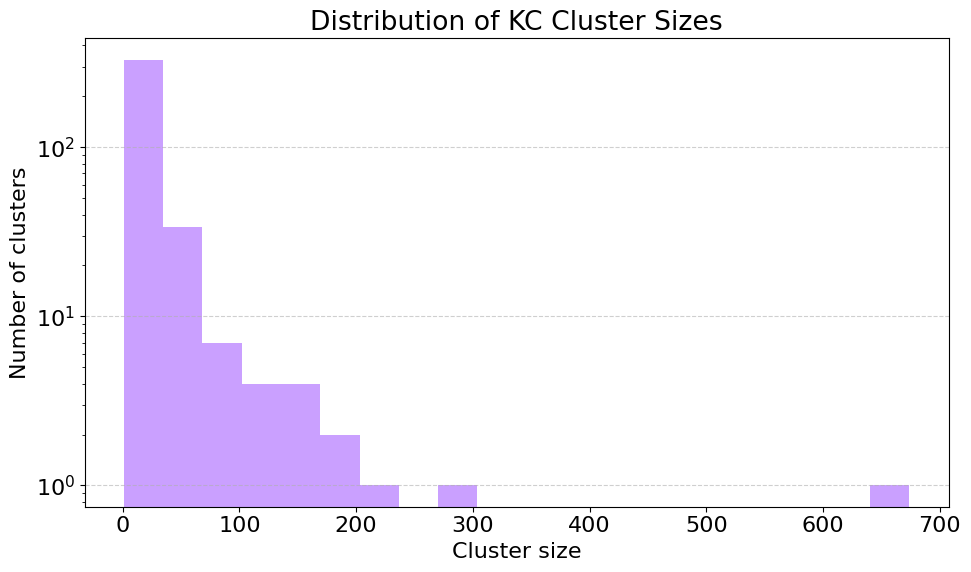

In [36]:
plt.figure(figsize=(10,6))
plt.rcParams["font.size"] = 16
plt.hist(cluster_sizes, bins=20, color="xkcd:pastel purple")

plt.title("Distribution of KC Cluster Sizes")
plt.xlabel("Cluster size")
plt.ylabel("Number of clusters")
plt.yscale("log")

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [23]:
cluster_kc_list = list(cluster_kcs.keys())

In [24]:
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(cluster_kc_list, convert_to_numpy=True)
print(embeddings.shape)

/home/vqchen_umass_edu/.conda/envs/LMKT/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


(384, 384)


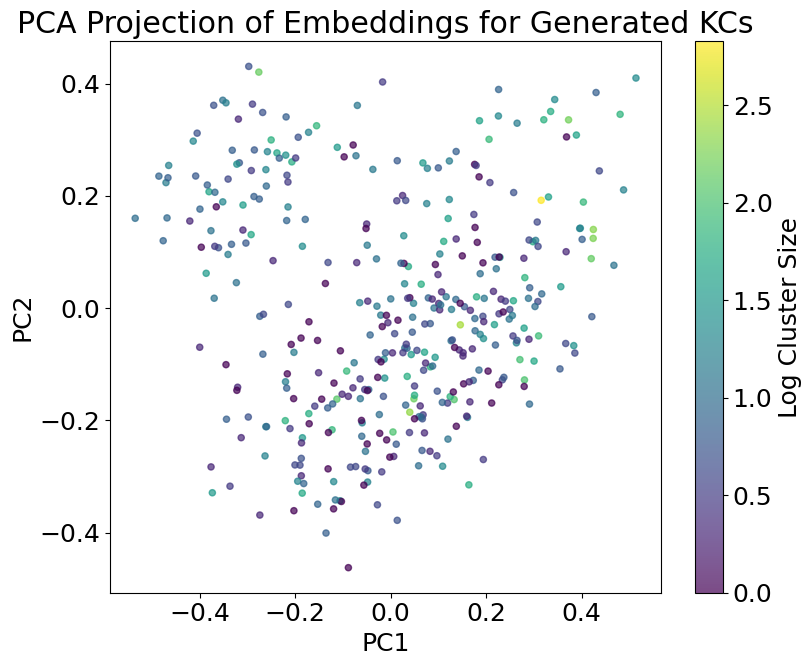

In [26]:
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

cluster_sizes = {k: len(v) for k,v in cluster_kcs.items()}
sizes = np.array([np.log10(cluster_sizes[l]) for l in cluster_kc_list])

plt.figure(figsize=(8.5,7))
plt.rcParams["font.size"] = 18
plt.scatter(emb_2d[:,0], emb_2d[:,1], s=20, alpha=0.7, cmap="viridis", c=sizes)
plt.title("PCA Projection of Embeddings for Generated KCs")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Log Cluster Size")
plt.tight_layout()
plt.show()


/home/vqchen_umass_edu/.conda/envs/LMKT/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


(385, 384)


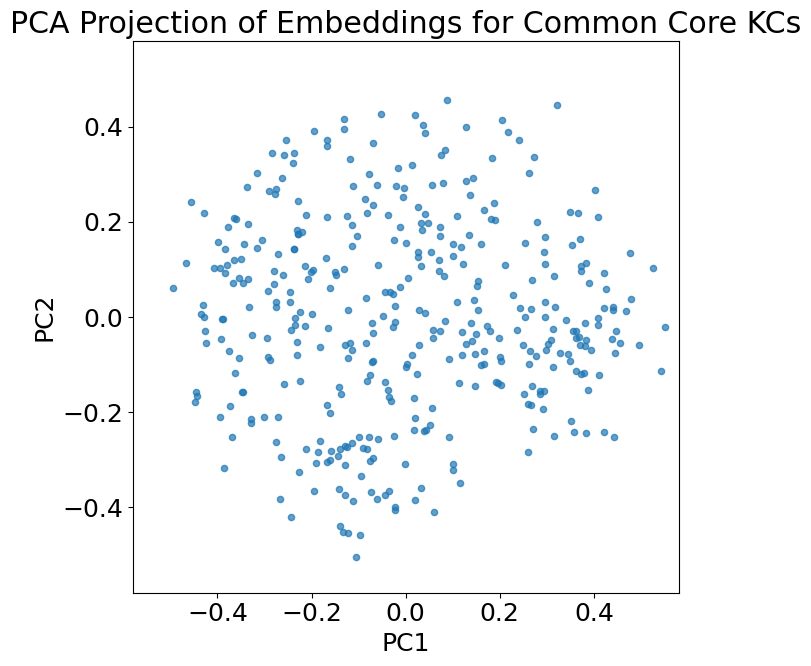

In [33]:
atc_kcs = [x["description"] for x in read_jsonl("../data/src/ATC/standards.jsonl") if x["level"] == "Standard"]
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(atc_kcs, convert_to_numpy=True)
print(embeddings.shape)

pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(7,7))
plt.rcParams["font.size"] = 18
plt.scatter(emb_2d[:,0], emb_2d[:,1], s=20, alpha=0.7)
plt.title("PCA Projection of Embeddings for Common Core KCs")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.xlim(-0.58, 0.58)
plt.ylim(-0.58, 0.58)
plt.tight_layout()
plt.show()


In [39]:
with open('final_generated_kc_list.json', 'w') as json_file:
    json.dump(cluster_kc_list, json_file)

### Mapping old kcs to new kcs

In [5]:
with open('old_to_new_kc.json', 'r') as json_file:
    old_to_new_kc = json.load(json_file)

In [6]:
train_data = pd.read_csv("train_gpt-4.1_updated.csv")
val_data = pd.read_csv("val_gpt-4.1_updated.csv")
test_data = pd.read_csv("test_gpt-4.1.csv")
train_data = pd.concat([train_data, val_data], axis=0).reset_index(drop=True)

In [7]:
all_dfs = [train_data.copy(), test_data.copy()]

In [8]:
with open('kcs_per_turn.json', 'r') as json_file:
    all_turn_kcs = json.load(json_file)

with open('correctness_per_turn.json', 'r') as json_file:
    all_correctness = json.load(json_file)

In [9]:
# same as function from section 2
def construct_dialogue_column(row):
    turns = literal_eval(row["turns"])
    dialogue = []
    curr_turn = {"turn": 1}
    i = 1
    for turn in turns:
        if turn["role"] == "tutor":
            curr_turn["teacher"] = turn["content"]
        elif turn["role"] == "student":
            if "teacher" not in curr_turn:
                i = 0
                curr_turn = {"turn": 0, "teacher":""}
            curr_turn["student"] = turn["content"]
            dialogue.append(curr_turn)
            i += 1
            curr_turn = {"turn": i}
    if "student" not in curr_turn and "teacher" in curr_turn:
        curr_turn["student"] = ""
        dialogue.append(curr_turn)
    return dialogue

for df in all_dfs:
    df["dialogue"] = df.apply(construct_dialogue_column, axis=1)

In [10]:
train_turn_nums = pd.read_csv("../data/annotated/eedi_train_atc.csv")["meta_data"].apply(lambda x: literal_eval(x)["num_turns"])
test_turn_nums = pd.read_csv("../data/annotated/eedi_test_atc.csv")["meta_data"].apply(lambda x: literal_eval(x)["num_turns"])

In [11]:
all_annotations = []
for i in range(all_dfs[0].shape[0]):
    curr_annotations = {}
    curr_kcs = all_turn_kcs[i]
    curr_correctness = all_correctness[i]
    for n in range(1, train_turn_nums.iloc[i]+1):
        turn = f"turn {n}"
        curr_annotations[turn] = {
            "correct": curr_correctness[turn]["correct"] if turn in curr_correctness else None,
            "kcs": [old_to_new_kc[kc] for kc in curr_kcs[turn]] if turn in curr_kcs else []
        }
    all_annotations.append(curr_annotations)
all_dfs[0]["annotation"] = pd.Series(all_annotations)
all_dfs[0]["meta_data"] = all_dfs[0]["annotation"].apply(lambda x: {"num_turns": len(x)})

In [12]:
all_annotations = []
for i in range(all_dfs[1].shape[0]):
    start_idx = all_dfs[0].shape[0]
    curr_annotations = {}
    curr_kcs = all_turn_kcs[start_idx:][i]
    curr_correctness = all_correctness[start_idx:][i]
    for n in range(1, test_turn_nums.iloc[i]+1):
        turn = f"turn {n}"
        curr_annotations[turn] = {
            "correct": curr_correctness[turn]["correct"] if turn in curr_correctness else None,
            "kcs": [old_to_new_kc[kc] for kc in curr_kcs[turn]] if turn in curr_kcs else []
        }
    all_annotations.append(curr_annotations)
all_dfs[1]["annotation"] = pd.Series(all_annotations)
all_dfs[1]["meta_data"] = all_dfs[1]["annotation"].apply(lambda x: {"num_turns": len(x)})

In [13]:
kt_dfs = [
    all_dfs[0][["key", "question", "turns", "annotation", "dialogue", "meta_data"]].reset_index().copy(),
    all_dfs[1][["key", "question", "turns", "annotation", "dialogue", "meta_data"]].reset_index().copy()
]

In [22]:
kt_dfs[0].to_csv("../data/annotated/eedi_train_gpt.csv", index=False)
kt_dfs[1].to_csv("../data/annotated/eedi_test_gpt.csv", index=False)

In [26]:
temp_kcs = set()
kt_dfs[0]["annotation"].apply(lambda x: [temp_kcs.add(kc) for turn in x.values() for kc in turn["kcs"]])

0                                [None, None, None, None]
1                                [None, None, None, None]
2       [None, None, None, None, None, None, None, Non...
3                                [None, None, None, None]
4                                [None, None, None, None]
                              ...                        
1571                             [None, None, None, None]
1572                       [None, None, None, None, None]
1573    [None, None, None, None, None, None, None, Non...
1574           [None, None, None, None, None, None, None]
1575    [None, None, None, None, None, None, None, Non...
Name: annotation, Length: 1576, dtype: object

In [27]:
len(temp_kcs)

361

In [68]:
atc_kcs = [x["id"] for x in read_jsonl("../data/src/ATC/standards.jsonl") if x["level"] == "Standard"]

In [69]:
len(atc_kcs)

385

In [48]:
train_data = pd.read_csv("train_gpt-4.1_updated.csv")

In [63]:
atc_kc_train_uniq = set()
train_data["question_standard_annotation"].apply(lambda kcs: [atc_kc_train_uniq.add(x) for x in literal_eval(kcs)] if not pd.isnull(kcs) else print(kcs))

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


0                                       None
1                                     [None]
2                               [None, None]
3                               [None, None]
4                                     [None]
                        ...                 
1177                                  [None]
1178                                  [None]
1179                            [None, None]
1180    [None, None, None, None, None, None]
1181                                  [None]
Name: question_standard_annotation, Length: 1182, dtype: object

In [64]:
pd.isnull(train_data["question_standard_annotation"])

0        True
1       False
2       False
3       False
4       False
        ...  
1177    False
1178    False
1179    False
1180    False
1181    False
Name: question_standard_annotation, Length: 1182, dtype: bool

In [66]:
len(atc_kc_train_uniq)

213